In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

%matplotlib inline
plt.ion()   # interactive mode

In [8]:
from torchsummary import summary

## 1. Loading data


In [9]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [10]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(160),  # Reduced from 224 to 160
        transforms.ColorJitter(brightness=0.1, contrast=0.1 , saturation = 0.1), #random brightness, contrast etc
        transforms.GaussianBlur(kernel_size=(15, 15)),
        transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(192),  # Reduced proportionally
        transforms.CenterCrop(160),  # Reduced from 224 to 160
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/media/user/volume2/students/s123md212_02/YaoHengji/4414/sg_food' 
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


In [11]:
device

device(type='cuda', index=0)

## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



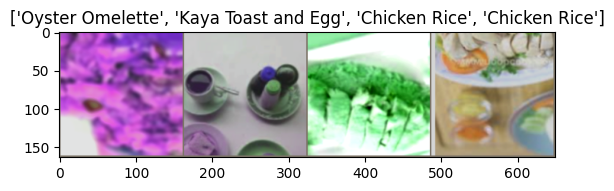

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Model Initailization

### 3.1 Define Models

In [37]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

# Load the pre-trained MobileNet v2 model for faster computation
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

/media/user/volume2/students/s123md212_02/anaconda3/envs/FYP/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/media/user/volume2/students/s123md212_02/anaconda3/envs/FYP/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/media/user/volume2/students/s123md212_02/anaconda3/envs/FYP/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are dep

### 3.2 Modify Models

In [38]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

# Modify MobileNet_v2
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, num_classes)

In [15]:
# Summary

# VGG16
summary(vgg16.to(device), input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]           1,792
              ReLU-2         [-1, 64, 160, 160]               0
            Conv2d-3         [-1, 64, 160, 160]          36,928
              ReLU-4         [-1, 64, 160, 160]               0
         MaxPool2d-5           [-1, 64, 80, 80]               0
            Conv2d-6          [-1, 128, 80, 80]          73,856
              ReLU-7          [-1, 128, 80, 80]               0
            Conv2d-8          [-1, 128, 80, 80]         147,584
              ReLU-9          [-1, 128, 80, 80]               0
        MaxPool2d-10          [-1, 128, 40, 40]               0
           Conv2d-11          [-1, 256, 40, 40]         295,168
             ReLU-12          [-1, 256, 40, 40]               0
           Conv2d-13          [-1, 256, 40, 40]         590,080
             ReLU-14          [-1, 256,

In [16]:
# ResNet18
summary(resnet18.to(device), input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

In [17]:
# Inception_v3
summary(inception_v3.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [39]:
# MobileNet_v2
summary(mobilenet_v2.to(device), input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 80, 80]             864
       BatchNorm2d-2           [-1, 32, 80, 80]              64
             ReLU6-3           [-1, 32, 80, 80]               0
            Conv2d-4           [-1, 32, 80, 80]             288
       BatchNorm2d-5           [-1, 32, 80, 80]              64
             ReLU6-6           [-1, 32, 80, 80]               0
            Conv2d-7           [-1, 16, 80, 80]             512
       BatchNorm2d-8           [-1, 16, 80, 80]              32
  InvertedResidual-9           [-1, 16, 80, 80]               0
           Conv2d-10           [-1, 96, 80, 80]           1,536
      BatchNorm2d-11           [-1, 96, 80, 80]             192
            ReLU6-12           [-1, 96, 80, 80]               0
           Conv2d-13           [-1, 96, 40, 40]             864
      BatchNorm2d-14           [-1, 96,

### 3.3 Dict for Models

In [42]:
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    "Inception_v3": inception_v3,
    "MobileNet_v2": mobilenet_v2
}

## 4. Training

In [43]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if is_inception and phase == 'train':
                    inputs = torch.stack([F.resize(input, size=(299, 299)) for input in inputs])

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [44]:
def visualize_training(val_acc_history):
    plt.figure()
    # 确保将 tensor 转移到 CPU
    val_acc_history_cpu = [h.cpu() for h in val_acc_history]
    plt.plot(val_acc_history_cpu)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Training History")
    plt.show()


Training VGG16...
Epoch 1/25
----------
train Loss: 1.6828 Acc: 0.2180
val Loss: 1.5017 Acc: 0.3600

Epoch 2/25
----------
train Loss: 1.4829 Acc: 0.3500
val Loss: 1.2912 Acc: 0.4733

Epoch 3/25
----------
train Loss: 1.2876 Acc: 0.5040
val Loss: 1.1345 Acc: 0.5867

Epoch 4/25
----------
train Loss: 1.1491 Acc: 0.5420
val Loss: 0.8536 Acc: 0.6667

Epoch 5/25
----------
train Loss: 1.0839 Acc: 0.5960
val Loss: 0.7337 Acc: 0.7067

Epoch 6/25
----------
train Loss: 0.9792 Acc: 0.6320
val Loss: 0.6370 Acc: 0.7533

Epoch 7/25
----------
train Loss: 0.9555 Acc: 0.6460
val Loss: 0.6138 Acc: 0.7800

Epoch 8/25
----------
train Loss: 0.9397 Acc: 0.6280
val Loss: 0.6335 Acc: 0.7533

Epoch 9/25
----------
train Loss: 0.9018 Acc: 0.6380
val Loss: 0.6153 Acc: 0.7133

Epoch 10/25
----------
train Loss: 0.8056 Acc: 0.6860
val Loss: 0.5873 Acc: 0.7600

Epoch 11/25
----------
train Loss: 0.8211 Acc: 0.6980
val Loss: 0.5374 Acc: 0.7933

Epoch 12/25
----------
train Loss: 0.8234 Acc: 0.6760
val Loss: 0.5

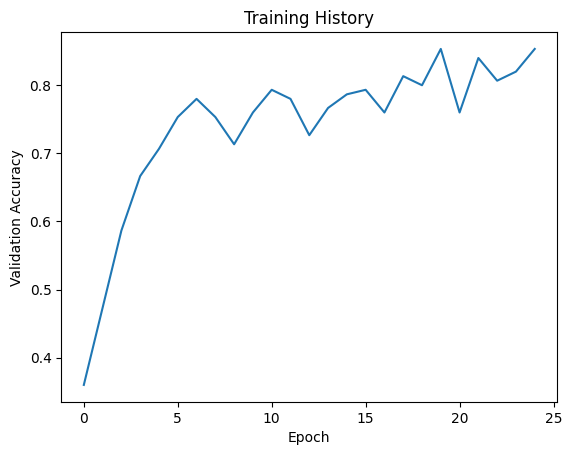

Training ResNet18...
Epoch 1/25
----------
train Loss: 1.6964 Acc: 0.2360
val Loss: 1.5908 Acc: 0.3067

Epoch 2/25
----------
train Loss: 1.5419 Acc: 0.3240
val Loss: 1.3949 Acc: 0.3533

Epoch 3/25
----------
train Loss: 1.4465 Acc: 0.3740
val Loss: 1.2049 Acc: 0.5600

Epoch 4/25
----------
train Loss: 1.2994 Acc: 0.4700
val Loss: 1.0900 Acc: 0.5600

Epoch 5/25
----------
train Loss: 1.1850 Acc: 0.5480
val Loss: 0.9621 Acc: 0.6667

Epoch 6/25
----------
train Loss: 1.1237 Acc: 0.5740
val Loss: 0.8740 Acc: 0.6933

Epoch 7/25
----------
train Loss: 1.0557 Acc: 0.5980
val Loss: 0.8315 Acc: 0.7333

Epoch 8/25
----------
train Loss: 0.9757 Acc: 0.6400
val Loss: 0.7692 Acc: 0.7667

Epoch 9/25
----------
train Loss: 0.9823 Acc: 0.6160
val Loss: 0.7142 Acc: 0.7667

Epoch 10/25
----------
train Loss: 0.8628 Acc: 0.6820
val Loss: 0.6708 Acc: 0.7667

Epoch 11/25
----------
train Loss: 0.8882 Acc: 0.6780
val Loss: 0.6466 Acc: 0.7467

Epoch 12/25
----------
train Loss: 0.8079 Acc: 0.7160
val Loss: 

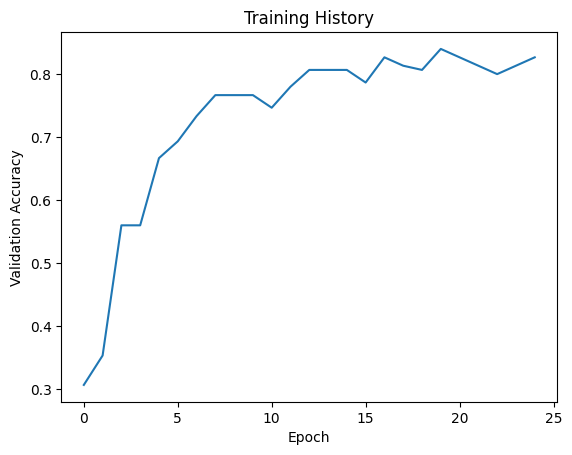

Training Inception_v3...
Epoch 1/25
----------
train Loss: 2.2953 Acc: 0.1820
val Loss: 1.6715 Acc: 0.2067

Epoch 2/25
----------
train Loss: 2.2346 Acc: 0.2500
val Loss: 1.6072 Acc: 0.3067

Epoch 3/25
----------
train Loss: 2.1690 Acc: 0.2840
val Loss: 1.5548 Acc: 0.3200

Epoch 4/25
----------
train Loss: 2.0835 Acc: 0.3380
val Loss: 1.5204 Acc: 0.3200

Epoch 5/25
----------
train Loss: 1.9971 Acc: 0.4040
val Loss: 1.5121 Acc: 0.3467

Epoch 6/25
----------
train Loss: 1.9171 Acc: 0.4620
val Loss: 1.4814 Acc: 0.4200

Epoch 7/25
----------
train Loss: 1.8345 Acc: 0.4920
val Loss: 1.4582 Acc: 0.4067

Epoch 8/25
----------
train Loss: 1.7222 Acc: 0.5360
val Loss: 1.3938 Acc: 0.4267

Epoch 9/25
----------
train Loss: 1.6284 Acc: 0.5620
val Loss: 1.5302 Acc: 0.3933

Epoch 10/25
----------
train Loss: 1.5900 Acc: 0.6200
val Loss: 1.4417 Acc: 0.4400

Epoch 11/25
----------
train Loss: 1.4526 Acc: 0.6120
val Loss: 1.4663 Acc: 0.4467

Epoch 12/25
----------
train Loss: 1.4033 Acc: 0.6360
val Lo

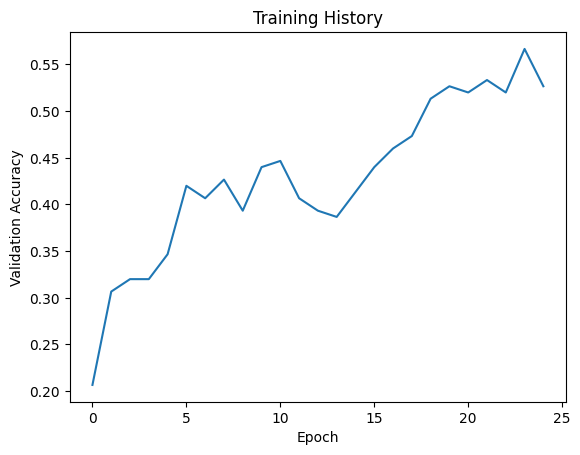

Training MobileNet_v2...
Epoch 1/25
----------
train Loss: 1.6995 Acc: 0.2040
val Loss: 1.5321 Acc: 0.3267

Epoch 2/25
----------
train Loss: 1.5644 Acc: 0.2700
val Loss: 1.3278 Acc: 0.5000

Epoch 3/25
----------
train Loss: 1.4180 Acc: 0.4100
val Loss: 1.1570 Acc: 0.6267

Epoch 4/25
----------
train Loss: 1.2503 Acc: 0.5000
val Loss: 0.9633 Acc: 0.6600

Epoch 5/25
----------
train Loss: 1.1218 Acc: 0.5920
val Loss: 0.8337 Acc: 0.7333

Epoch 6/25
----------
train Loss: 0.9763 Acc: 0.6740
val Loss: 0.7215 Acc: 0.7200

Epoch 7/25
----------
train Loss: 0.9418 Acc: 0.6420
val Loss: 0.6418 Acc: 0.7533

Epoch 8/25
----------
train Loss: 0.9007 Acc: 0.6720
val Loss: 0.6175 Acc: 0.7600

Epoch 9/25
----------
train Loss: 0.8232 Acc: 0.6960
val Loss: 0.5923 Acc: 0.7667

Epoch 10/25
----------
train Loss: 0.7413 Acc: 0.7320
val Loss: 0.5209 Acc: 0.7867

Epoch 11/25
----------
train Loss: 0.7046 Acc: 0.7400
val Loss: 0.4821 Acc: 0.8267

Epoch 12/25
----------
train Loss: 0.6933 Acc: 0.7560
val Lo

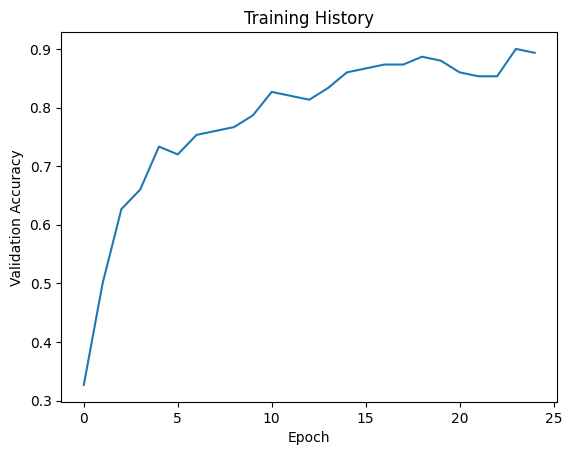

In [45]:
# Loop through each model for training
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define Criterion
    criterion = nn.CrossEntropyLoss()
    
    # Define Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Inception_v3
    is_inception = (model_name == "Inception_v3")
    
    trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=is_inception)
    
    # Visualize Training Result
    visualize_training(val_acc_history)
    
    # Save Checkpoints
    torch.save(trained_model.state_dict(), f"/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/{model_name}.pth")


**Train Swin Transformer (tiny) with lr scheduler**

In [22]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [23]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /media/user/volume2/students/s123md212_02/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/media/user/volume2/students/s123md212_02/anaconda3/envs/FYP/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [24]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.head)
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
model = model.to(device)
print(model.head)

Linear(in_features=768, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)


In [25]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [26]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                # Resize inputs for both training and validation phases
                inputs = torch.stack([F.resize(input, size=(224, 224)) for input in inputs])

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


Epoch 1/25
----------
train Loss: 1.5160 Acc: 0.3300
val Loss: 1.2490 Acc: 0.6733

Epoch 2/25
----------
train Loss: 1.2338 Acc: 0.5340
val Loss: 0.9514 Acc: 0.7933

Epoch 3/25
----------
train Loss: 1.1265 Acc: 0.6360
val Loss: 0.7785 Acc: 0.8867

Epoch 4/25
----------
train Loss: 1.0186 Acc: 0.7040
val Loss: 0.7201 Acc: 0.8933

Epoch 5/25
----------
train Loss: 1.0002 Acc: 0.6800
val Loss: 0.6982 Acc: 0.8867

Epoch 6/25
----------
train Loss: 0.9553 Acc: 0.7140
val Loss: 0.6808 Acc: 0.9133

Epoch 7/25
----------
train Loss: 0.9533 Acc: 0.7300
val Loss: 0.6611 Acc: 0.9200

Epoch 8/25
----------
train Loss: 0.8917 Acc: 0.7560
val Loss: 0.6631 Acc: 0.9133

Epoch 9/25
----------
train Loss: 0.9020 Acc: 0.7320
val Loss: 0.6611 Acc: 0.8933

Epoch 10/25
----------
train Loss: 0.9103 Acc: 0.7500
val Loss: 0.7157 Acc: 0.8467

Epoch 11/25
----------
train Loss: 0.8584 Acc: 0.7860
val Loss: 0.6735 Acc: 0.8733

Epoch 12/25
----------
train Loss: 0.8448 Acc: 0.7860
val Loss: 0.6869 Acc: 0.8533

E

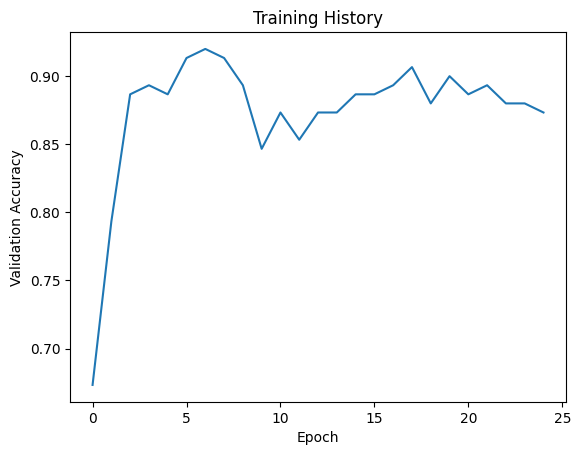

In [27]:
trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    
# Visualize Training Result
visualize_training(val_acc_history)
    
# Save Checkpoints
torch.save(trained_model.state_dict(), "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/swin_tiny.pth")


# 5. Prediction and Evaluation

In [28]:
# Load the pre-trained Swin_tiny model
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
swin_tiny = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

Using cache found in /media/user/volume2/students/s123md212_02/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [29]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

# Modify Swin_tiny
swin_tiny.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

In [46]:
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    "Inception_v3": inception_v3,
    "MobileNet_v2": mobilenet_v2,
    "SwinTransformer_tiny": swin_tiny
}

In [48]:
# Data normalization for testing
test_data_transform = transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ])

data_dir = '/media/user/volume2/students/s123md212_02/YaoHengji/4414/sg_food' 

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
test_image_dataset = sg_food_dataset(root=os.path.join(data_dir, 'test'),
                                     class_id=selected_classes,
                                     transform=test_data_transform) 
class_names = test_image_dataset.classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)

test_dataset_size = len(test_image_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


device(type='cuda', index=0)

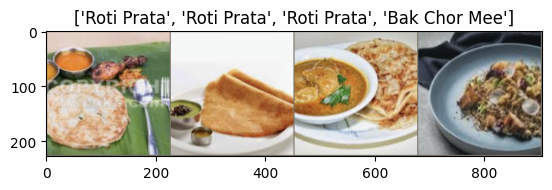

In [49]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [56]:
best_model_paths = {
    "VGG16": "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/VGG16.pth",
    "ResNet18": "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/ResNet18.pth",
    "Inception_v3": "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/Inception_v3.pth",
    "MobileNet_v2": "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/MobileNet_v2.pth",
    "SwinTransformer_tiny": "/media/user/volume2/students/s123md212_02/YaoHengji/4414/model/swin_tiny.pth"
}

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(model,test_dataloader,class_names):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):   
                label = labels[i]
                #for confusion matrix
                y_true.append(label.to('cpu'))
                y_pred.append(predicted[i].to('cpu'))
                
        
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["BCM","CR","KTE","OO","RP"])
    disp.plot()
    plt.title("confusion matrix")
    plt.show()
    
    

Testing VGG16...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.87      0.83      0.85       200
      Chicken Rice       0.80      0.81      0.80       200
Kaya Toast and Egg       0.85      0.91      0.88       200
   Oyster Omelette       0.82      0.83      0.83       200
        Roti Prata       0.93      0.87      0.90       200

          accuracy                           0.85      1000
         macro avg       0.85      0.85      0.85      1000
      weighted avg       0.85      0.85      0.85      1000



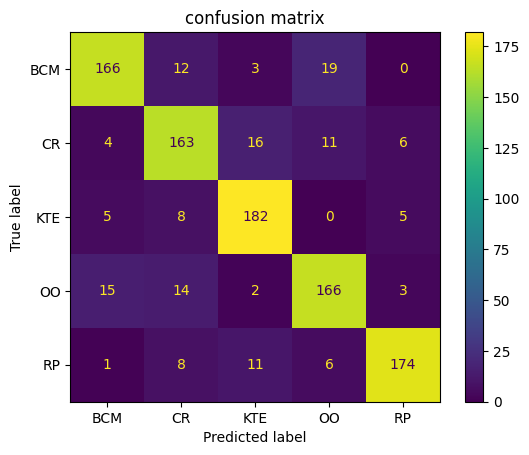

Testing ResNet18...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.82      0.78      0.80       200
      Chicken Rice       0.78      0.72      0.75       200
Kaya Toast and Egg       0.84      0.84      0.84       200
   Oyster Omelette       0.76      0.82      0.79       200
        Roti Prata       0.83      0.86      0.84       200

          accuracy                           0.81      1000
         macro avg       0.81      0.81      0.80      1000
      weighted avg       0.81      0.81      0.80      1000



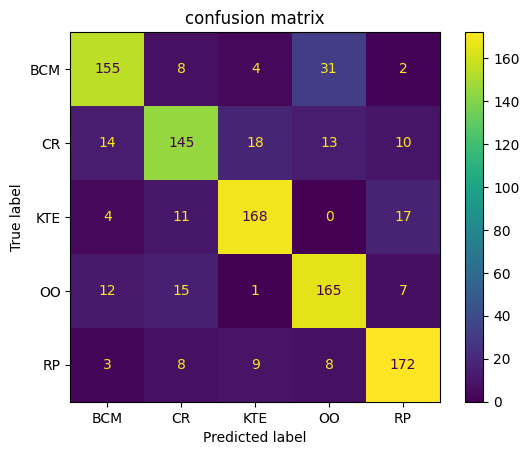

Testing Inception_v3...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.81      0.71      0.76       200
      Chicken Rice       0.71      0.73      0.72       200
Kaya Toast and Egg       0.69      0.90      0.78       200
   Oyster Omelette       0.76      0.81      0.79       200
        Roti Prata       0.89      0.65      0.75       200

          accuracy                           0.76      1000
         macro avg       0.77      0.76      0.76      1000
      weighted avg       0.77      0.76      0.76      1000



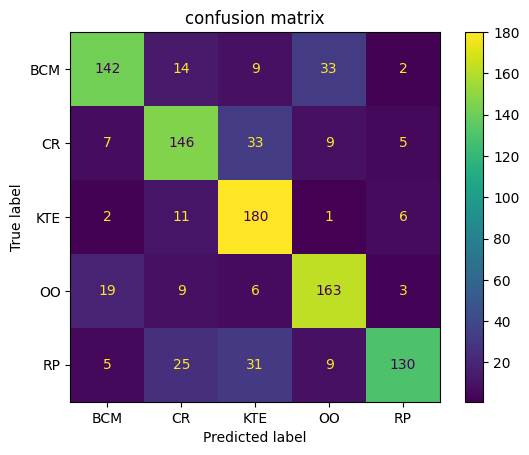

Testing MobileNet_v2...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.97      0.76      0.85       200
      Chicken Rice       0.82      0.79      0.81       200
Kaya Toast and Egg       0.89      0.87      0.88       200
   Oyster Omelette       0.75      0.89      0.81       200
        Roti Prata       0.80      0.89      0.84       200

          accuracy                           0.84      1000
         macro avg       0.85      0.84      0.84      1000
      weighted avg       0.85      0.84      0.84      1000



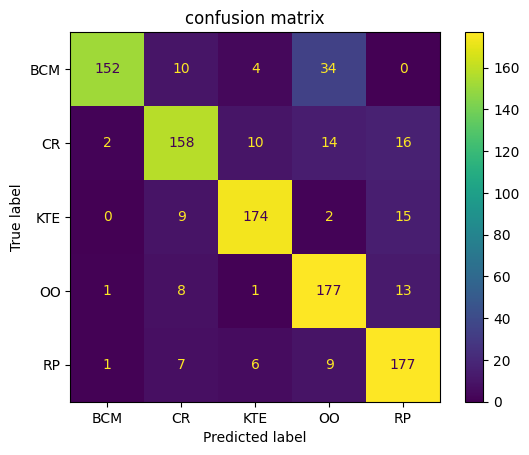

Testing SwinTransformer_tiny...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.93      0.77      0.84       200
      Chicken Rice       0.78      0.91      0.84       200
Kaya Toast and Egg       0.90      0.92      0.91       200
   Oyster Omelette       0.85      0.79      0.82       200
        Roti Prata       0.82      0.87      0.84       200

          accuracy                           0.85      1000
         macro avg       0.85      0.85      0.85      1000
      weighted avg       0.85      0.85      0.85      1000



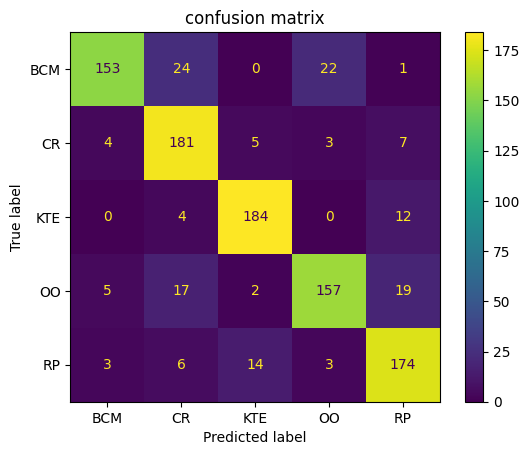

In [57]:
for model_name, model in models_dict.items():
    #if model_name == "VGG16":
    #    continue
    print(f"Testing {model_name}...")
    
    model.to(device)
    model.load_state_dict(torch.load(best_model_paths[model_name]),strict=False)
    model.eval()
    evaluate(model,test_dataloader,class_names)
    